In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

import pandas as pd
import numpy as np

### **Before this make sure to do the following**:

* Log into your Kaggle account
* From the site header, click on your user profile picture, then on “My Account” from the dropdown menu
* Scroll down to the section of the page labelled API
* Create a new token (click on “Create New API Token”)
* Upload the file `kaggle.json` with the authentication token to the Google Colab workspace in your current directory

In [2]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

 99% 1.61G/1.62G [00:06<00:00, 307MB/s]
100% 1.62G/1.62G [00:06<00:00, 258MB/s]


In [4]:
!unzip ocular-disease-recognition-odir5k.zip

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [5]:
df = pd.read_excel('ODIR-5K/ODIR-5K/data.xlsx')

In [6]:
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


In [7]:
import re

# get cols with dummy-encoded classes (all only one letter)
class_cols = [i for i in df.columns if re.match(r'[A-Z]$', i)]


In [8]:
# rows with more than one classification

df.loc[df[class_cols].sum(axis = 1) > 1]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
6,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1
7,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
11,11,60,Female,11_left.jpg,11_right.jpg,moderate non proliferative retinopathy，hyperte...,moderate non proliferative retinopathy，hyperte...,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,4591,65,Male,4591_left.jpg,4591_right.jpg,mild nonproliferative retinopathy,hypertensive retinopathy,0,1,0,0,0,1,0,0
3426,4598,64,Male,4598_left.jpg,4598_right.jpg,post retinal laser surgery，severe nonprolifera...,post retinal laser surgery，severe nonprolifera...,0,1,0,0,0,0,0,1
3428,4600,51,Male,4600_left.jpg,4600_right.jpg,post retinal laser surgery，moderate non prolif...,post retinal laser surgery，moderate non prolif...,0,1,0,0,0,0,0,1
3480,4659,42,Male,4659_left.jpg,4659_right.jpg,mild nonproliferative retinopathy,intraretinal microvascular abnormality,0,1,0,0,0,0,0,1


In [9]:
# create separate dataframes for right and left eyes

left_df = df.drop(['Right-Fundus', 'Right-Diagnostic Keywords'], axis = 1)\
           .rename({'Left-Fundus': 'Image', 'Left-Diagnostic Keywords': 'Diagnostic Keywords'}, axis = 1)

right_df = df.drop(['Left-Fundus', 'Left-Diagnostic Keywords'], axis = 1)\
            .rename({'Right-Fundus': 'Image', 'Right-Diagnostic Keywords': 'Diagnostic Keywords'}, axis = 1)


In [10]:
# concatenate right and left eye dfs --> NOTE: both eyes for the same person still with the same diagnosis for dummy-encoded vars (but both eyes may not be affected)
all_eyes_df = pd.concat([left_df, right_df], axis = 0).sort_values('ID')

all_eyes_df

,ID,Patient Age,Patient Sex,Image,Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,cataract,0,0,0,1,0,0,0,0
0,0,69,Female,0_right.jpg,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,normal fundus,1,0,0,0,0,0,0,0
1,1,57,Male,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,4689,54,Male,4689_left.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
3499,4784,58,Male,4784_left.jpg,hypertensive retinopathy，age-related macular d...,0,0,0,0,1,1,0,0


In [11]:
keywords = [i for sublist in list(all_eyes_df['Diagnostic Keywords'].str.split(',|，')) for i in sublist]

keywords = list(set(keywords))

In [12]:
# 102 keywords confirms finding by He et al. ("Self-speculation of clinical features based on knowledge distillation for accurate ocular disease classification")
len(keywords)

102

In [13]:
keywords[:10]

['mild nonproliferative retinopathy',
 'pathological myopia',
 'pigment epithelium proliferation',
 'intraretinal hemorrhage',
 'severe nonproliferative retinopathy',
 'morning glory syndrome',
 'suspected moderate non proliferative retinopathy',
 'myopic maculopathy',
 'arteriosclerosis',
 'proliferative diabetic retinopathy']

In [14]:
# N: normal, image offset (??), low image quality (??)
# D: (mild, moderate, etc.) non[-| ]?proliferative retinopathy, (suspicious, suspected, proliferative, severse etc.) diabetic retinopathy
# G: (suspected) glaucoma
# C: (suspected) cataract
# A: dry age-related macular degeneration, wet age-related macular degeneration
# H: hypertensive retinopathy
# M: myopic retinopathy, myopia retinopathy, myopic maculopathy, pathological myopia
# O: old central retinal vein occlusion, suspected microvascular anomalies, diffuse chorioretinal atrophy, retinal pigment epithelial hypertrophy
# retinal vascular sheathing, arteriosclerosis, white vessel, oval yellow-white atrophy, retinal detachment, tessellated fundus, refractive media opacity
# wedge white line change, epiretinal membrane over the macula, optic nerve atrophy, post retinal laser surgery, choroidal nevus, white vessel
# optic disk epiretinal membrane, diffuse chorioretinal atrophy, drusen, central serous chorioretinopathy, refractive media opacity, central retinal vein occlusion
# depigmentation of the retinal pigment epithelium, tessellated fundus, branch retinal vein occlusion, vitreous opacity, epiretinal membrane over the macula
# vitreous degeneration, suspected retinitis pigmentosa, post laser photocoagulation, retina fold, macular coloboma, retinal vascular sheathing
# peripapillary atrophy, peripapillary atrophy, wedge white line change, morning glory syndrome, central retinal artery occlusion, optic disc edema
# anterior segment image, macular epiretinal membrane, suspected retinal vascular sheathing, old branch retinal vein occlusion, oval yellow-white atrophy
# abnormal pigment, myelinated nerve fibers, suspected abnormal color of optic disc, atrophy, vascular loops, branch retinal artery occlusion
# epiretinal membrane, retinitis pigmentosa, diffuse retinal atrophy, pigment epithelium proliferation, macular hole, silicone oil eye, old chorioretinopathy
# retinochoroidal colomba, choroidal nevus, optic discitis, congenital choroidal coloboma, wedge-shaped change, macular pigmentation disorder, lens dust
# retinal pigment epithelial hypertrophy, post retinal laser surgery, retinal artery macroaneurysm, old choroiditis, punctate inner choroidopathy
# idiopathic choroidal neovascularization, spotted membranous change, fundus laser photocoagulation spots, arteriosclerosis, rhegmatogenous retinal detachment
# suspected macular epimacular membrane, chorioretinal atrophy with pigmentation proliferation

In [15]:
diagnostic_df = all_eyes_df

# split diagnostic words on comma and space
diagnostic_df['conditions'] = diagnostic_df['Diagnostic Keywords'].str.split(',|，')

diagnostic_df

,ID,Patient Age,Patient Sex,Image,Diagnostic Keywords,N,D,G,C,A,H,M,O,conditions
0,0,69,Female,0_left.jpg,cataract,0,0,0,1,0,0,0,0,[cataract]
0,0,69,Female,0_right.jpg,normal fundus,0,0,0,1,0,0,0,0,[normal fundus]
1,1,57,Male,1_left.jpg,normal fundus,1,0,0,0,0,0,0,0,[normal fundus]
1,1,57,Male,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,[normal fundus]
2,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,"[laser spot, moderate non proliferative retino..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3497,4689,54,Male,4689_left.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,[mild nonproliferative retinopathy]
3498,4690,57,Male,4690_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,[mild nonproliferative retinopathy]
3498,4690,57,Male,4690_left.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,[mild nonproliferative retinopathy]
3499,4784,58,Male,4784_left.jpg,hypertensive retinopathy，age-related macular d...,0,0,0,0,1,1,0,0,"[hypertensive retinopathy, age-related macular..."


In [16]:
# create a row for each condition (duplicates all other info but now one row per condition in list)
diagnostic_df = diagnostic_df.explode('conditions')

In [17]:
# create variable column with all of the conditions (N, D, ...) and a values column with 1 or 0 if condition present
diagnostic_df = diagnostic_df.melt(id_vars = ['ID', 'Image', 'conditions'], value_vars = class_cols)

# remove zero values in value col (since these conditions are not present)
diagnostic_df = diagnostic_df.loc[diagnostic_df.value != 0].sort_values('ID')

In [18]:
diagnostic_df.head(15)

,ID,Image,conditions,variable,value
24021,0,0_left.jpg,cataract,C,1
24022,0,0_right.jpg,normal fundus,C,1
2,1,1_left.jpg,normal fundus,N,1
3,1,1_right.jpg,normal fundus,N,1
8013,2,2_right.jpg,moderate non proliferative retinopathy,D,1
8012,2,2_left.jpg,moderate non proliferative retinopathy,D,1
8011,2,2_left.jpg,laser spot,D,1
56053,2,2_left.jpg,laser spot,O,1
56054,2,2_left.jpg,moderate non proliferative retinopathy,O,1
56055,2,2_right.jpg,moderate non proliferative retinopathy,O,1


In [19]:
# create a conditional col based on whether or not certain descriptors in conditions col --> try to correct the class label for each image
def correct_class(df):
  if (re.search(r'^normal', df['conditions'])):
    df.variable = "N"
  elif (re.search(r'hypertensive', df['conditions'])):
    df.variable = "H"
  elif (re.search(r'(myopia|myopic)', df['conditions'])):
    df.variable = "M"
  elif (re.search(r'(diabetes|diabetic|non[-| ]?proliferative)', df['conditions'])):
    df.variable = "D"
  elif (re.search(r'glaucoma', df['conditions'])):
    df.variable = "G"
  elif (re.search(r'cataract', df['conditions'])):
    df.variable = "C"
  elif (re.search(r'macular degeneration', df['conditions'])):
    df.variable = "A"
  else:
    df.variable = "O"
  return df
    

In [20]:
diagnostic_df = diagnostic_df.apply(correct_class, axis = 1)

# remove any duplicates
diagnostic_df = diagnostic_df.drop_duplicates()

In [21]:
diagnostic_df.variable.value_counts()

cat_counts = list(diagnostic_df.variable.value_counts())

In [22]:
diagnostic_df.variable.value_counts()

N    3098
D    1801
O    1711
G     326
C     314
A     280
M     268
H     193
Name: variable, dtype: int64

In [23]:
# create new names for images based on condition assigned

diagnostic_df[['prefix', 'suffix']] = diagnostic_df['Image'].str.split('.', expand = True)

diagnostic_df['image_name'] = diagnostic_df['prefix'] + '_' + diagnostic_df['variable'] + '.' + diagnostic_df['suffix']

diagnostic_df

,ID,Image,conditions,variable,value,prefix,suffix,image_name
24021,0,0_left.jpg,cataract,C,1,0_left,jpg,0_left_C.jpg
24022,0,0_right.jpg,normal fundus,N,1,0_right,jpg,0_right_N.jpg
2,1,1_left.jpg,normal fundus,N,1,1_left,jpg,1_left_N.jpg
3,1,1_right.jpg,normal fundus,N,1,1_right,jpg,1_right_N.jpg
8013,2,2_right.jpg,moderate non proliferative retinopathy,D,1,2_right,jpg,2_right_D.jpg
...,...,...,...,...,...,...,...,...
16009,4690,4690_left.jpg,mild nonproliferative retinopathy,D,1,4690_left,jpg,4690_left_D.jpg
40031,4784,4784_left.jpg,hypertensive retinopathy,H,1,4784_left,jpg,4784_left_H.jpg
40032,4784,4784_left.jpg,age-related macular degeneration,A,1,4784_left,jpg,4784_left_A.jpg
40033,4784,4784_right.jpg,hypertensive retinopathy,H,1,4784_right,jpg,4784_right_H.jpg


In [24]:
multilabel_df = pd.get_dummies(diagnostic_df.drop('value', axis = 1), prefix = '', prefix_sep = '', columns = ['variable'])

multilabel_df

,ID,Image,conditions,prefix,suffix,image_name,A,C,D,G,H,M,N,O
24021,0,0_left.jpg,cataract,0_left,jpg,0_left_C.jpg,0,1,0,0,0,0,0,0
24022,0,0_right.jpg,normal fundus,0_right,jpg,0_right_N.jpg,0,0,0,0,0,0,1,0
2,1,1_left.jpg,normal fundus,1_left,jpg,1_left_N.jpg,0,0,0,0,0,0,1,0
3,1,1_right.jpg,normal fundus,1_right,jpg,1_right_N.jpg,0,0,0,0,0,0,1,0
8013,2,2_right.jpg,moderate non proliferative retinopathy,2_right,jpg,2_right_D.jpg,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16009,4690,4690_left.jpg,mild nonproliferative retinopathy,4690_left,jpg,4690_left_D.jpg,0,0,1,0,0,0,0,0
40031,4784,4784_left.jpg,hypertensive retinopathy,4784_left,jpg,4784_left_H.jpg,0,0,0,0,1,0,0,0
40032,4784,4784_left.jpg,age-related macular degeneration,4784_left,jpg,4784_left_A.jpg,1,0,0,0,0,0,0,0
40033,4784,4784_right.jpg,hypertensive retinopathy,4784_right,jpg,4784_right_H.jpg,0,0,0,0,1,0,0,0


In [25]:
# dictionary with aggregation conditions (i.e., join values in conditions col for each group (image) and sum across cols for dummy cols)
agg_dict = {'conditions': lambda x: ', '.join(x)}

for i in class_cols:
  agg_dict[i] = 'sum'


multilabel_df = multilabel_df.groupby(['ID', 'Image']).agg(agg_dict).reset_index()

for i in class_cols:
  multilabel_df[i] = multilabel_df[i].astype('int64')

multilabel_df

,ID,Image,conditions,N,D,G,C,A,H,M,O
0,0,0_left.jpg,cataract,0,0,0,1,0,0,0,0
1,0,0_right.jpg,normal fundus,1,0,0,0,0,0,0,0
2,1,1_left.jpg,normal fundus,1,0,0,0,0,0,0,0
3,1,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0
4,2,2_left.jpg,"moderate non proliferative retinopathy, laser ...",0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6995,4689,4689_right.jpg,normal fundus,1,0,0,0,0,0,0,0
6996,4690,4690_left.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
6997,4690,4690_right.jpg,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0
6998,4784,4784_left.jpg,"hypertensive retinopathy, age-related macular ...",0,0,0,0,1,1,0,0


In [26]:
# creating power labels method from: https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b

# create new column where assign new labels for each combo of conditions
multilabel_df['new_label'] = multilabel_df.apply(lambda x: x.N + 2 * x.D + 4 * x.G + 8 * x.C + 16 * x.A + 32 * x.H + 64 * x.M + 128 * x.O - 1, axis = 1)

In [27]:
# top_classes = [i for i in multilabel_df.new_label.unique() if multilabel_df.new_label.value_counts()[i] > 10]

# mean of number of images in each section
class_mean = int(np.mean(multilabel_df.new_label.value_counts()))

class_mean

179

In [28]:
# function adapted from: https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b

# array of new power labels in training data (some do not appear in training data since only one image with that power label)
power_classes = [i for i in multilabel_df.new_label.unique() if multilabel_df.new_label.value_counts()[i] < class_mean]

power_classes.sort()

# dictionary with keys: power labels, values: number of times each label appears
power_counts = dict(multilabel_df.new_label.value_counts()[power_classes])

data_df = multilabel_df.copy()

# randomly oversample data for each classes with less than the mean number of images across all classes
for i in power_classes:
  temp_df = multilabel_df.iloc[np.random.choice(np.where(multilabel_df['new_label'] == i)[0], size = class_mean)]
  data_df = data_df.append(temp_df, ignore_index = True)

In [29]:
data_df

,ID,Image,conditions,N,D,G,C,A,H,M,O,new_label
0,0,0_left.jpg,cataract,0,0,0,1,0,0,0,0,7
1,0,0_right.jpg,normal fundus,1,0,0,0,0,0,0,0,0
2,1,1_left.jpg,normal fundus,1,0,0,0,0,0,0,0,0
3,1,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,0
4,2,2_left.jpg,"moderate non proliferative retinopathy, laser ...",0,1,0,0,0,0,0,1,129
...,...,...,...,...,...,...,...,...,...,...,...,...
12365,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385
12366,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385
12367,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385
12368,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385


In [30]:
# rank labels in order to use for class weights later on (since need weight keys to be from 0 through K - 1, K = number of classes)
data_df['rank'] = data_df['new_label'].rank(method = 'dense') - 1

data_df['rank'] = data_df['rank'].astype('int')

data_df

,ID,Image,conditions,N,D,G,C,A,H,M,O,new_label,rank
0,0,0_left.jpg,cataract,0,0,0,1,0,0,0,0,7,4
1,0,0_right.jpg,normal fundus,1,0,0,0,0,0,0,0,0,0
2,1,1_left.jpg,normal fundus,1,0,0,0,0,0,0,0,0,0
3,1,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,0,0
4,2,2_left.jpg,"moderate non proliferative retinopathy, laser ...",0,1,0,0,0,0,0,1,129,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12365,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385,38
12366,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385,38
12367,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385,38
12368,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385,38


In [31]:
# new labels
print(np.unique(data_df['new_label']))

print(len(np.unique(data_df['rank'])))

np.unique(data_df['rank'])

[  0   1   3   5   7   9  11  15  17  19  31  33  35  39  47  63  65  67
  79 127 128 129 131 133 135 137 143 145 159 191 255 256 257 259 261 263
 287 383 385]
39


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [32]:
# add new ids for each image --> count the number of times each image repeated
data_df['label_ids'] = data_df.groupby(['Image', 'new_label']).cumcount()

# separate beginning identifier and jpg ending
data_df[['prefix', 'suffix']] = data_df['Image'].str.split('.', expand = True)

# create new image name with beginning identifier, rank (new class), label (indicates which repeat the image is), jpg ending
data_df['new_name'] = data_df.apply(lambda x: '{}_{}_{}.{}'.format(x.prefix, x['rank'], str(x.label_ids), x.suffix), axis = 1)

data_df

,ID,Image,conditions,N,D,G,C,A,H,M,O,new_label,rank,label_ids,prefix,suffix,new_name
0,0,0_left.jpg,cataract,0,0,0,1,0,0,0,0,7,4,0,0_left,jpg,0_left_4_0.jpg
1,0,0_right.jpg,normal fundus,1,0,0,0,0,0,0,0,0,0,0,0_right,jpg,0_right_0_0.jpg
2,1,1_left.jpg,normal fundus,1,0,0,0,0,0,0,0,0,0,0,1_left,jpg,1_left_0_0.jpg
3,1,1_right.jpg,normal fundus,1,0,0,0,0,0,0,0,0,0,0,1_right,jpg,1_right_0_0.jpg
4,2,2_left.jpg,"moderate non proliferative retinopathy, laser ...",0,1,0,0,0,0,0,1,129,21,0,2_left,jpg,2_left_21_0.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12365,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385,38,90,993_right,jpg,993_right_38_90.jpg
12366,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385,38,91,993_right,jpg,993_right_38_91.jpg
12367,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385,38,92,993_right,jpg,993_right_38_92.jpg
12368,993,993_right.jpg,"lens dust, mild nonproliferative retinopathy, ...",0,1,0,0,0,0,0,3,385,38,93,993_right,jpg,993_right_38_93.jpg


In [33]:
# demonstrate results
data_df.loc[data_df.Image == "465_left.jpg"]

,ID,Image,conditions,N,D,G,C,A,H,M,O,new_label,rank,label_ids,prefix,suffix,new_name
928,465,465_left.jpg,"drusen, cataract, lens dust",0,0,0,1,0,0,0,2,263,35,0,465_left,jpg,465_left_35_0.jpg
11654,465,465_left.jpg,"drusen, cataract, lens dust",0,0,0,1,0,0,0,2,263,35,1,465_left,jpg,465_left_35_1.jpg
11655,465,465_left.jpg,"drusen, cataract, lens dust",0,0,0,1,0,0,0,2,263,35,2,465_left,jpg,465_left_35_2.jpg
11656,465,465_left.jpg,"drusen, cataract, lens dust",0,0,0,1,0,0,0,2,263,35,3,465_left,jpg,465_left_35_3.jpg
11657,465,465_left.jpg,"drusen, cataract, lens dust",0,0,0,1,0,0,0,2,263,35,4,465_left,jpg,465_left_35_4.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11828,465,465_left.jpg,"drusen, cataract, lens dust",0,0,0,1,0,0,0,2,263,35,175,465_left,jpg,465_left_35_175.jpg
11829,465,465_left.jpg,"drusen, cataract, lens dust",0,0,0,1,0,0,0,2,263,35,176,465_left,jpg,465_left_35_176.jpg
11830,465,465_left.jpg,"drusen, cataract, lens dust",0,0,0,1,0,0,0,2,263,35,177,465_left,jpg,465_left_35_177.jpg
11831,465,465_left.jpg,"drusen, cataract, lens dust",0,0,0,1,0,0,0,2,263,35,178,465_left,jpg,465_left_35_178.jpg


In [34]:
# group by image name and aggregate all alternative image names given the number of repeats for that image
files_df_labels = data_df.groupby('Image').agg({'new_name': lambda x: ', '.join(x)})

# dictionary with keys: original file name, values: list of alternative file names based on number of times repeated
files_dict = dict(zip(files_df_labels.index, files_df_labels['new_name'].str.split(', ')))

In [35]:
files_dict['465_left.jpg'][:5]

['465_left_35_0.jpg',
 '465_left_35_1.jpg',
 '465_left_35_2.jpg',
 '465_left_35_3.jpg',
 '465_left_35_4.jpg']

In [36]:
!rm -r test_dir

rm: cannot remove 'test_dir': No such file or directory


In [37]:
%%bash

cd ODIR-5K/ODIR-5K/Training\ Images

# number of files in Training Images directory
ls | wc -l

cd ../../..

# make new directory
mkdir test_dir

cd test_dir

# list all files in test_dir/training_images
ls | wc -l

7000
0


In [38]:
import shutil

In [39]:
%%bash

cd test_dir

# make subdirectories for each class
mkdir -p {0..38}

# number of subdirectories
ls -d */ | wc -l

39


In [40]:
old_prefix = 'ODIR-5K/ODIR-5K/Training Images/'

new_prefix = 'test_dir/'

# for the keys, values in dictionary --> for the elts in values (lists of elts) --> create new file names and make copies and move to test_dir directory
for file, new_file_names in files_dict.items():
  for new_file in new_file_names:
    if new_file != '':
      file_name = f'{old_prefix}{file}'
      new_file_name = f'{new_prefix}{new_file}'
      shutil.copyfile(file_name, new_file_name)

In [41]:
%%bash

# contains all images and 39 directories for classes 0 throguh 38
cd test_dir

ls | wc -l

12409


In [42]:
# list of files (not directories) in test_dir folder
new_files = [f for f in os.listdir(new_prefix) if os.path.isfile(f'{new_prefix}{f}')]

# move each file in test_dir folder into the directory with the correct class (e.g., 0...38) based on "rank" ID included in the image name
for file in new_files:
  shutil.move(f'{new_prefix}{file}', '{}{}'.format(new_prefix, file.split('.')[0].split('_')[-2]))


In [43]:
%%bash

# show that only directories left in test_dir since all images moved into those directories
cd test_dir

ls | wc -l


39


### **Visualization**

In [184]:
# get categories and labels and counts
label_conditions = pd.DataFrame(data_df.groupby(['rank'] + class_cols).size()).reset_index().rename({0: 'size'}, axis = 1)

label_conditions = label_conditions.loc[label_conditions['size'] > 1]

# add list of class labels
label_conditions['label'] = label_conditions.apply(lambda x: [col for col in class_cols if x[col] > 0], axis = 1)

label_conditions

,rank,N,D,G,C,A,H,M,O,size,label
0,0,1,0,0,0,0,0,0,0,2818,[N]
1,1,0,1,0,0,0,0,0,0,1389,[D]
2,2,0,0,1,0,0,0,0,0,218,[G]
3,3,0,1,1,0,0,0,0,0,208,"[D, G]"
4,4,0,0,0,1,0,0,0,0,262,[C]
5,5,0,1,0,1,0,0,0,0,192,"[D, C]"
6,6,0,0,1,1,0,0,0,0,181,"[G, C]"
7,7,0,0,0,0,1,0,0,0,237,[A]
9,8,0,1,0,0,1,0,0,0,195,"[D, A]"
10,9,0,0,1,0,1,0,0,0,193,"[G, A]"


In [185]:
# create dictionary with rank (class label for the images) as the key and the associated condition(s) as the values
class_names = dict(zip(label_conditions['rank'].astype(str), label_conditions.label))

In [186]:
# each batch in train_ds or validation_ds tensor: 32 image tensors (224 x 224 x 3); 1D tensor with 32 class labels

from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "/content/test_dir/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly --> change to 224 since expected size for MobileNet
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        



Found 12370 files belonging to 39 classes.
Using 9896 files for training.
Found 12370 files belonging to 39 classes.
Using 2474 files for validation.


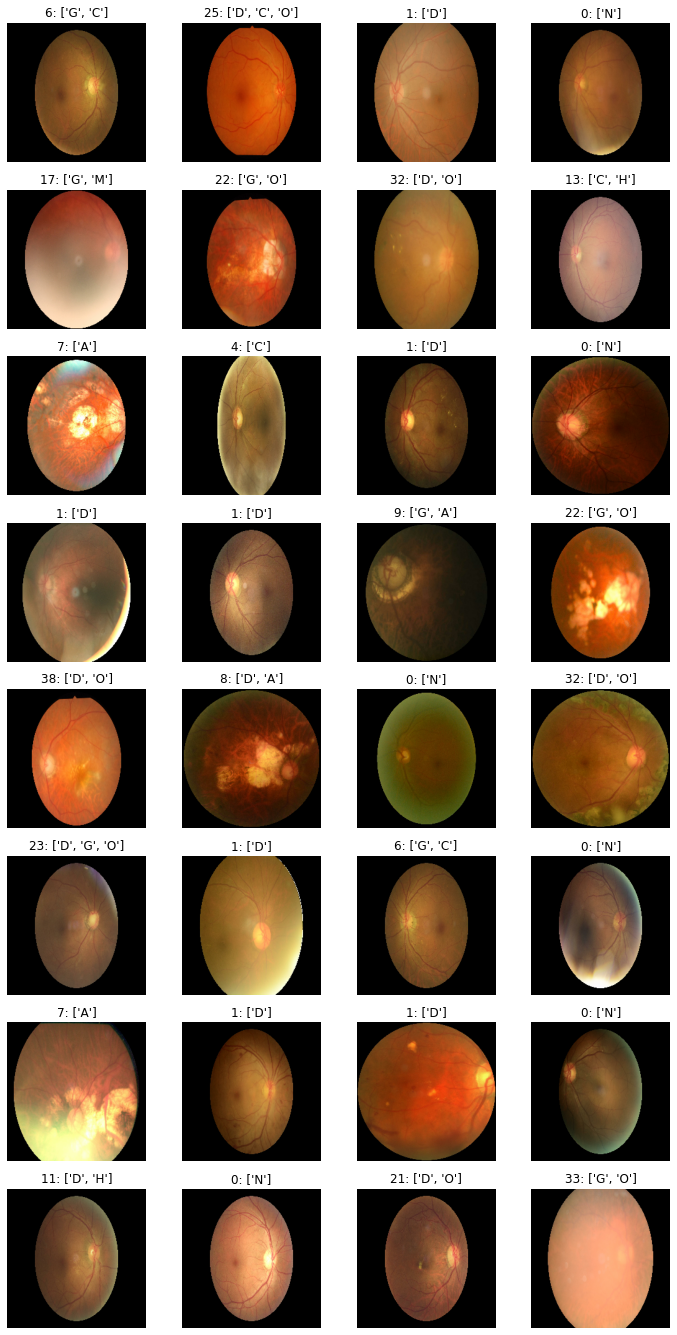

In [187]:
# Visualize one training batch (32 images)
n_rows = 8
n_cols = 4

plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(str(labels[i].numpy()) + ": " + str(class_names[str(labels[i].numpy())]), fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


#### **Used to create a zipped version of the directories and images to upload to Rivanna for running Python scripts on the cluster**

In [ ]:
# !zip -r '/content/test_dir.zip' '/content/test_dir'

In [ ]:
# from google.colab import files

# files.download('/content/test_dir.zip')

#### [**Transfer learning and fine-tuning with pre-trained `MobileNetV2` network**](https://www.tensorflow.org/tutorials/images/transfer_learning)

**1. Configure dataset for performance**
* [`tf.data.Dataset.prefetch`](https://www.tensorflow.org/guide/data_performance): decouple time when data produced from time when data consumed
  * Prefetch and preprocess next set of inputs as model training on previous set
  * Background thread and internal buffer to prefetch elements from input dataset ahead of request
  * Num of elts to prefetch ≥ num of batches consumed by a single training step
  * Manually tune or use `tf.data.AUTOTUNE`: prompts `tf.data` runtine to tune value dynamically at runtime


**2. Data augmentation**
* [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip): randomly flips images during training
  * Arguments
    * `mode`: string indicating which flip mode to use (e.g., `"horizontal"` for left-right)
    * `seed`
* [`tf.keras.layers.RandomRotation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation): randomly rotates images during training
  * Arguments
    * `seed`
    * `factor`: float represented as fraction of 2Π or tuple of size 2 for lower and upper bound for rotating clockwise and counter-clockwise (if one float then the same for both)
* [`tf.keras.layers.RandomContrast`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomContrast): preprocessing layer that randomly adjusts contrast during training
  * Arguments
    * `factor`: positive float represented as a fraction of value or tuple of size 2 for lower and upper bounds
      * When a single float then randomly pick between [1.0 - lower, 1.0 + upper]
    * `seed`


**3. Rescale pixel values**
* [`tf.keras.applications.mobilenet_v2.preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/preprocess_input): returns preprocessed `numpy.array` or `tf.Tensor` with input pixel values scaled between -1 and 1

* Alternative: `tf.keras.layers.Rescaling(1./127.5, offset = 01)`


**4. Create base `MobileNet` model from pre-trained convolution network**
* `MobileNetV2` model trained on the ImageNet dataset
* Pick layer of `MobileNetV2` to use for feature extraction
  * Use last layer before flattening $\rightarrow$ **bottleneck layer** (more generality vs. final / top layer)
  * Specify `include_top = False` to remove last classification layer(s) on "top"
* `next(iterator[, default])`: return the next item from the iterator


**5. Feature extraction**
* **5a.** Freeze convolutional base model $\rightarrow$ set `layer.trainable = False` (or `base_model.trainable = False` for all layers) to prevent weights from being updated during training
* **5b.** Add layers to allow for classification of images
  * Average over `7x7` spatial locations with [`tf.keras.layers.GlobalAveragePooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) (global average pooling for spatial data)
    * Arguments
      * `keepdims=False`: whether to keep spatial dimensions $\rightarrow$ default False $\therefore$ ouput: 2D tensor with shape (batch_size, channels) = (32,
  * Add `tf.keras.layers.Dense` to convert features into a single prediction per image
    * Use activation function `"softmax"` to return probabilities image is of a particular class for 18 classes (i.e., places)
* **5c.** Build a model by chaining together data augmentation, rescaling, `base_model`, feature layers using the `Keras Functional API`
  * Note: `training = False` for `base_model` since model contains a `BatchNormalization` layer $\rightarrow$ runs in inference mode and does not update its mean and variance stats
  * [**`Keras functional API`**](https://www.tensorflow.org/guide/keras/functional): create more flexible models than `tf.keras.Sequential API`
    * Builds a graph of layers since deep learning model (usually) as directed acyclic graph (DAG) of layers
    * Create input node: `inputs = keras.Input(shape = (784,))`
      * Contains info about shape, `dtype` of input data
    * Create new node in graph of layers by calling a layer on `inputs` object: `dense = layers.Dense(64, activation = "relu") \\ x = dense(inputs)`
      * Layer call draws an arrow from inputs to new layer $\rightarrow$ pass inputs to `dense` layer and get `x` as the output
    * Add another hidden layer: `x = layers.Dense(64, activation = "relu")(x)`
      * Pass `x` to next hidden layer and store output as `x`
    * Add output layer: `outputs = layers.Dense(10)(x)`
    * Create a model: `model = keras.Model(inputs = inputs, outputs = outputs)`
    * Training, evaluation, inference the same as `Sequential` models


**6. Compile the model**
* `model.compile(optimizer, loss, metrics)`
  * optimizer: [`tf.keras.optimizers.Adam(learning_rate = base_learning_rate)`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) $\rightarrow$ implements Adam algorith, a stochastic gradient descent method based on adaptive estimation of first- and secod-order moments
    * Higher computaional efficiency, lower memory requirements
  * loss: `"sparse_categorical_crossentropy"` $\rightarrow$ use for two or more classes when labels are integers
    * [`tf.keras.losses.SparseCategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
  * metrics: [`['accuracy']`](https://keras.io/api/metrics/accuracy_metrics/) $\rightarrow$ (num times preds = labels) / count


**7. Train the model**


**8. Fine tuning**
* Only training a few layers on top of `MobileNetV2` nase model $\rightarrow$ can inrease performance to train weights of top layers of pre-trained `base_model` to force more generic params to associate with specific dataset
  * Only fine-tune small num of top layers (not whole `MobileNetV2` model) $\rightarrow$ higher up (later) layers more specialized $\therefore$ more specific to dataset on which model trained
* **8a** Un-freeze the top (i.e., later) layers of the `base_model` (the `MobileNetV2` instance) but keep bottom (i.e., earlier) layers untrainable 
* **8b.** Re-compile the model $\rightarrow$ use a lower learning rate to prevent model from overfitting quickly
  * [`tf.keras.optimizers.RMSprop`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop): RMSprop alogirthm maintains a moving (discounted_ average of square of gradients $\rightarrow$ divides gradient by root of average
* **8c.** Continue training the model $\rightarrow$ use argument `initial_epoch` to start training again based on training model to convergence previously
  * `initial_epoch = history.epoch[-1]` $\rightarrow$ begin at last epoch of first round of training (when all `base_model` params frozen)



**Model Checkpoints**:
* [`tf.keras.callbacks.ModelCheckpoint`](https://keras.io/api/callbacks/model_checkpoint/): callback to save keras model or model weights at some frequency
  * Use to save the weights that yield the maximum validation accuracy since model may begin to overfit to the training data $\therefore$ the last epoch may not have the weights that yield the best validation accuracy
  * Access the weights: `model.load_weights(checkpoint_path)`
* [`tf.keras.callbacks.EarlyStopping`](https://keras.io/api/callbacks/early_stopping/): stop training the model when a monitored metric has stopped improving
  * `patience`: number of epochs without improvement to wait until the training process stops


**Saving and Loadings Models**
* Save just the weights will callbacks (i.e., `tf.keras.callbacks.ModelCheckpoint`) or [save the entire model](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) as a `SavedModel`
  * Make a directory: `!mkdir -p saved_model`
  * Save the model using the directory path: `model.save('saved_model/my_model')`
  * Load a new instance of the model: `new_model = tf.keras.models.load_model('saved_model/my_model')`


**Tensorflow on Rivanna**
* TensorFlow on Rivanna: https://www.rc.virginia.edu/userinfo/rivanna/software/tensorflow/
* UVA software containers (creating singularity containers) and docker hub info: https://www.rc.virginia.edu/userinfo/rivanna/software/containers/
* Docker images on Rivanna: https://www.rc.virginia.edu/userinfo/howtos/rivanna/docker-images-on-rivanna/
* uvarc/rivanna-docker: https://github.com/uvarc/rivanna-docker
* Explanation for code `singularity pull docker://uvarc/tensorflow:2.8.0` to create local copy of container image in a local directory:
https://hub.docker.com/r/uvarc/tensorflow

**Additional sources for a different approach (when data is stored with a directory structure s.t. images for each class are in separate folders**
* From the DEEPLIZARD website and YouTube channel
  * [MobileNet Image Classification With TensorFlow's Keras API](https://deeplizard.com/learn/video/OO4HD-1wRN8) $\rightarrow$ default size for `MobileNet`: (224, 224)
  * [Process Images For Fine-Tuned MobileNet With TensorFlow's Keras API](https://deeplizard.com/learn/video/FNqp4ZY0wDY)
  * [Fine-Tuning MobileNet On Custom Data Set With TensorFlow's Keras API](https://deeplizard.com/learn/video/Zrt76AIbeh4)


#### **Organizing and Correctly Labeling Files**
* Search for matches with regex using `re.search`: https://stackabuse.com/python-check-if-string-contains-substring/
* Multiple if else conditions for conditional col: https://stackoverflow.com/questions/48569166/multiple-if-else-conditions-in-pandas-dataframe-and-derive-multiple-columns
* Pandas - dataframe groupby - how to get sum of multiple columns (using `agg` and a `lambda` function): https://stackoverflow.com/questions/46431243/pandas-dataframe-groupby-how-to-get-sum-of-multiple-columns

* Couting the number of files in a directory witn Linux using `ls | wc -l`: https://devconnected.com/how-to-count-files-in-directory-on-linux/
* How to convert two columns of a dataframe to a dictionary with `dict(zip(df.col1, df.col2))`: https://cmdlinetips.com/2021/04/convert-two-column-values-from-pandas-dataframe-to-a-dictionary/
* Listing files in a directory with `os.listdir('dir_name')`: https://www.codegrepper.com/code-examples/python/pandas+list+files+in+directory
* Using the `os` module: https://docs.python.org/3/library/os.html
* Copying files in Python with the `shutil` module: https://stackoverflow.com/questions/123198/how-to-copy-files
* Using the `shutil` module: https://docs.python.org/3/library/shutil.html 
* Dictionary comprehensions: https://www.datacamp.com/community/tutorials/python-dictionary-comprehension
* Create multiple subdirectories in Linux with one command (`mkdir -p {dir1,dir2,...}`: https://www.howtogeek.com/275069/how-to-create-multiple-subdirectories-with-one-linux-command/
* Only listing subdirectories in a directory in Linux with `ls -d */`: https://www.cyberciti.biz/faq/linux-list-just-directories-or-directory-names/
* Number rows in a group in increasing order in pandas: https://stackoverflow.com/questions/37997668/pandas-number-rows-within-group-in-increasing-order
* List only files in the current directory with `os.listdir()` and `os.path.isfile()`: https://stackoverflow.com/questions/11968976/list-files-only-in-the-current-directory
* Download files from Google Colab to Google Drive with `from google.colab import files`: https://predictivehacks.com/?all-tips=how-to-download-files-and-folders-from-colab


#### **Handling Imbalanced Data**

* **Calculating class weights to use when modeling with imbalanced data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#train_a_model_with_class_weights**
* **Creating power labels and function to over/undersample classes to balance the data: https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b**


#### **Multi-label classification websites**

* Classification on an imbalanced dataset: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

* Multi-label classification with NN keras: https://towardsdatascience.com/multi-label-image-classification-with-neural-network-keras-ddc1ab1afede

* Multi-label classification in tensorflow: https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72


* **Multi-label classification in tensorflow: https://medium.com/deep-learning-with-keras/how-to-solve-multi-label-classification-problems-in-deep-learning-with-tensorflow-keras-7fb933243595

* Video version of above article: https://www.youtube.com/watch?v=5MQ63pDxULw

* Google Colab notebook: https://colab.research.google.com/drive/1dpojRslAA15q4tswH_9j8WIQRo0BITSp?usp=sharing#scrollTo=Q3iCuaVXNLhS

* tf.data.Dataset API: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
  * `from_tensor_slices`

* tf.io.decode_jpeg: https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg

* uint8: https://docs.microsoft.com/en-us/openspecs/windows_protocols/ms-dtyp/a88ed362-a905-4ed2-85f5-cfc8692c9842#:~:text=A%20UINT8%20is%20an%208,is%20not%20reserved%20for%20signing

* tf.io.read_file: https://www.tensorflow.org/api_docs/python/tf/io/read_file

* tf.py_function: https://www.tensorflow.org/api_docs/python/tf/py_function

* How to use the tf.data.Dataset.map() function in TensorFlow: https://www.gcptutorials.com/article/how-to-use-map-function-with-tensorflow-datasets

* Prefetching: https://www.tensorflow.org/guide/data_performance#prefetching

* numpy.squeeze: https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html

* Combinations of activation and loss functions in different situations: https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8


#### **Visualization**
* Convert scalar tensor to a scalar variable with `.numpy()`: https://stackoverflow.com/questions/37049411/tensorflow-how-to-convert-scalar-tensor-to-scalar-variable-in-python

* Outline for assignment 2: `M3.4 Assignment 2: Designing CNN Architecture to recognize UVA Historical Landmarks.ipynb`


#### **Ensemble Models**
* Workflow for normalizing and testing weights for ensemble models: https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/#:~:text=A%20weighted%20ensemble%20is%20an,the%20performance%20of%20the%20model

* `itertools.product(*iterables, repeat=1)`: https://docs.python.org/3/library/itertools.html#itertools.product

* Element-wise multiplication of two lists with `zip`: https://stackoverflow.com/questions/10271484/how-to-perform-element-wise-multiplication-of-two-lists

* `tf.keras.layers.Rescaling` to rescale pixel values within neural network: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling

* Creating an ensemble model from pre-trained models: https://www.tensorflow.org/guide/keras/functional

* Renaming a model with `model._name = "NAME"` to prevent errors about models being named the same thing in ensemble model: https://stackoverflow.com/questions/56886442/error-when-trying-to-rename-a-pretrained-model-on-tf-keras

#### **GitHub**
* Creating a personal access token (instead of using a password): https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token

* Git Large File Storage: https://git-lfs.github.com/
  * **Steps**
    * Dowload v3.1.4 (mac - Intel Silicon)
    * `brew install git-lfs`
    * `git lfs install`
    * `cd ..Desktop/repos`
    * `git clone https://github.com/cew4pf/DS6050-eye-project.git`
    * `cd DS6050-eye-project/`
    * `git lfs track "*.zip"`
    * `git add .gitattributes`
    * `git add test_dir.zip`
    * `git commit -m "Zipped data created with Google Colab"`
    * `git push origin main`

